In [1]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import shap

In [3]:
# Load the main dataset
application_train = pd.read_csv("application_train.csv")

# Load additional datasets
bureau = pd.read_csv("bureau.csv")  # Previous loans from other banks
bureau_balance = pd.read_csv("bureau_balance.csv")  # Monthly history of previous loans
pos_cash = pd.read_csv("POS_CASH_balance.csv")  # Point-of-sale (POS) and cash loan history
credit_card = pd.read_csv("credit_card_balance.csv")  # Credit card monthly balance
previous_app = pd.read_csv("previous_application.csv")  # Previous loan applications
installments = pd.read_csv("installments_payments.csv")  # Loan installment payment history

In [4]:
# Merge Bureau Data (Previous Loans)
bureau_agg = bureau.groupby("SK_ID_CURR").agg({
    "AMT_CREDIT_SUM": "sum",  # Total credit from other banks
    "AMT_CREDIT_SUM_DEBT": "sum",  # Total outstanding debt
    "AMT_CREDIT_SUM_OVERDUE": "sum",  # Total overdue amount
}).reset_index()

bureau_agg.rename(columns={
    "AMT_CREDIT_SUM": "TOTAL_CREDIT_BUREAU",
    "AMT_CREDIT_SUM_DEBT": "TOTAL_DEBT_BUREAU",
    "AMT_CREDIT_SUM_OVERDUE": "TOTAL_OVERDUE_BUREAU"
}, inplace=True)

# Merge with main dataset
application_train = application_train.merge(bureau_agg, on="SK_ID_CURR", how="left")

In [5]:
# Merge POS Loan Data
pos_agg = pos_cash.groupby("SK_ID_CURR").agg({
    "SK_ID_PREV": "count",  # Number of POS loans
    "CNT_INSTALMENT_FUTURE": "sum"  # Remaining installments
}).reset_index()

pos_agg.rename(columns={"SK_ID_PREV": "TOTAL_POS_LOANS", "CNT_INSTALMENT_FUTURE": "POS_REMAINING_INSTALLMENTS"}, 
               inplace=True)

# Merge with main dataset
application_train = application_train.merge(pos_agg, on="SK_ID_CURR", how="left")

In [6]:
# Merge Credit Card Data
credit_card_agg = credit_card.groupby("SK_ID_CURR").agg({
    "AMT_BALANCE": "sum",  # Total credit card balance
    "AMT_CREDIT_LIMIT_ACTUAL": "sum"  # Total credit limit
}).reset_index()

credit_card_agg.rename(columns={"AMT_BALANCE": "TOTAL_CREDIT_CARD_BALANCE", "AMT_CREDIT_LIMIT_ACTUAL": "TOTAL_CREDIT_LIMIT"}
                       , inplace=True)

# Merge with main dataset
application_train = application_train.merge(credit_card_agg, on="SK_ID_CURR", how="left")

In [7]:
# Fill missing values with 0
application_train.fillna(0, inplace=True)

# Convert categorical variables into numerical format
cat_cols = application_train.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    application_train[col] = le.fit_transform(application_train[col].astype(str))

In [8]:
# Drop ID columns
X = application_train.drop(columns=['SK_ID_CURR', 'TARGET'])
y = application_train['TARGET']

# Scale the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [10]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [11]:
# Train XGBoost
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

Random Forest Accuracy: 0.9195486399037446
XGBoost Accuracy: 0.9201014584654407
XGBoost AUC-ROC: 0.5110955989877384


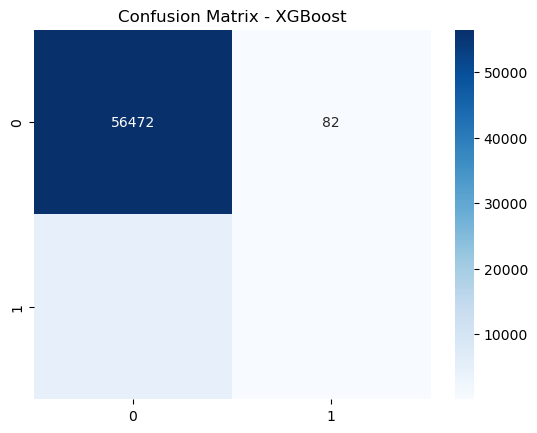

In [12]:
# Evaluate Model Performance
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost AUC-ROC:", roc_auc_score(y_test, y_pred_xgb))

# Confusion Matrix for XGBoost
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.show()

In [13]:
# Hyperparameter Tuning for XGBoost
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

print("Tuned XGBoost Accuracy:", accuracy_score(y_test, y_pred_best_xgb))
print("Tuned XGBoost AUC-ROC:", roc_auc_score(y_test, y_pred_best_xgb))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Tuned XGBoost Accuracy: 0.9200851990959791
Tuned XGBoost AUC-ROC: 0.5148665234277418


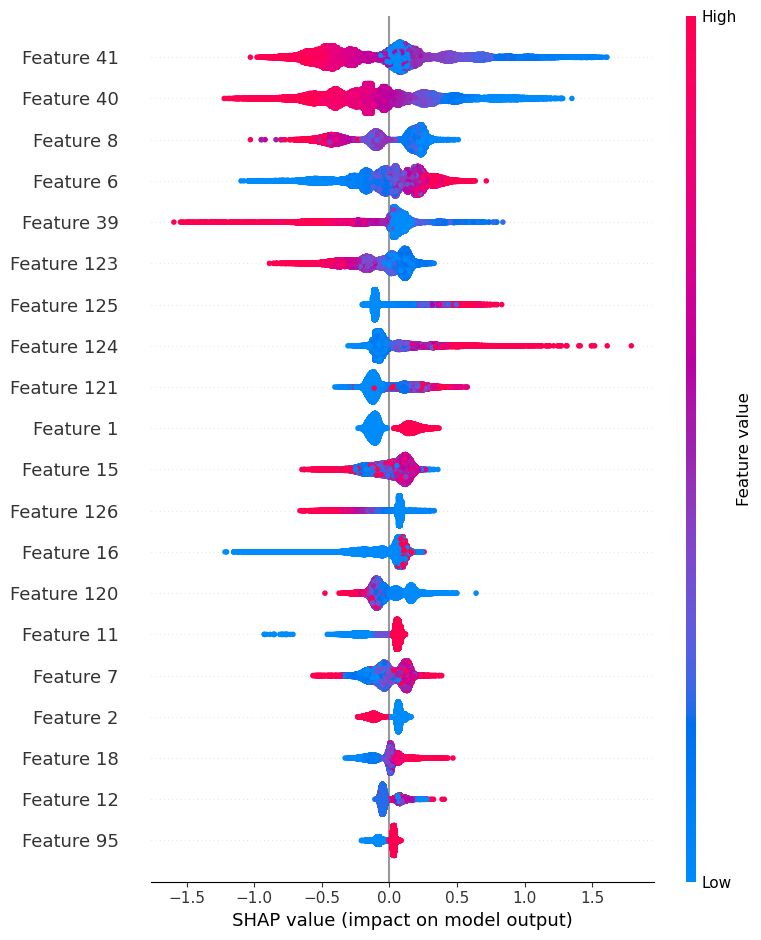

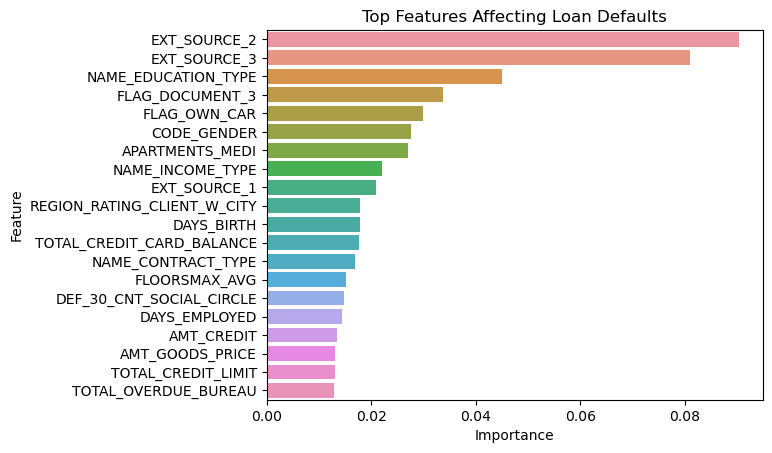

In [14]:
# Feature Importance Analysis using SHAP
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

# Feature Importance Plot
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': 
                                   best_xgb.feature_importances_}).sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feature_importance[:20])
plt.title('Top Features Affecting Loan Defaults')
plt.show()

#### SHAP values are based on Shapley values from cooperative game theory, which determine how much each "player" (feature) contributes to the total "payout" (model prediction).
#### SHAP decomposes a model's output by summing each feature's impact and calculating a value that represents each feature's contribution to the model's outcome.
#### SHAP values help understand the importance of each feature, explain the model's decisions, and identify potential biases or inconsistencies.
#### In a loan approval model, SHAP can show how much each feature (e.g., credit score, income, debt-to-income ratio) contributes to the final decision for any individual applicant.nt. 